# Decomposition of unitary gates

## Background
An arbitrary unitary gate on a quantum register can be decomposed into a sequence of gates, which act on single qubits or can be written as a single-qubit gates with control qubits. Such a decomposition can be obtained with the function `unitaryDecomposer` of geqo. This method is based on a step-wise elimination of matrix entries and it does not analyse or use the structure of the matrix. In general, this method can lead to an exponential number of gates in the number of qubits.

The ideas behind the decomposition methods are described in the following two articles:

- A. Barenco, C.H. Bennett, R. Cleve, D.P. DiVincenzo, N. Margolus, P. Shor, T. Sleator, J.A. Smolin, H. Weinfurter: "Elementary gates for quantum computation", Phys Rev A, 1995 Nov; 52(5):3457-3467.
- G. Cybenko: "Reducing quantum computations to elementary unitary operations", Computing in Science & Engineering, vol. 3, no. 2, pp. 27-32.

In [1]:
from geqo.core import Sequence, BasicGate
from geqo.gates import (
    PauliX,
    PauliY,
    Rx,
    Hadamard,
    CNOT,
    Toffoli,
    SwapQubits,
    Rzz,
    SGate,
)
from geqo.simulators import simulatorUnitarySymPy, simulatorStatevectorNumpy
from geqo.visualization import plot_mpl
from geqo.algorithms import unitaryDecomposer
import numpy as np
import math

## Example: Decomposition of $X\otimes X$
- the general decomposition method can be applied to the unitary operation $X\otimes X$, which consists of two single-qubit gates
- the algorithm eliminates the entries of the corresponding unitary matrix step-by-step

True

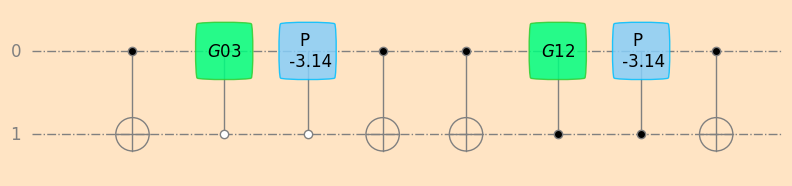

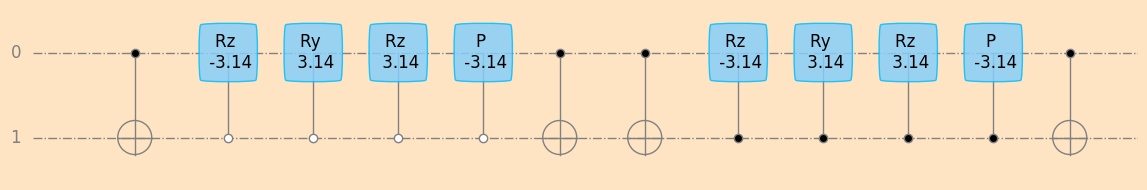

In [2]:
xx = np.array(
    [
        [0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j, 1.0 + 0.0j],
        [0.0 + 0.0j, 0.0 + 0.0j, 1.0 + 0.0j, 0.0 + 0.0j],
        [0.0 + 0.0j, 1.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j],
        [1.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j],
    ]
)

# decompose xx into CNOT, Givens, and Phase gates
seq_xx_givens, xx_params_givens = unitaryDecomposer(xx)
sim1 = simulatorUnitarySymPy(2)
sim1.values = xx_params_givens
plot_mpl(seq_xx_givens, backend=sim1, style="geqo")

# decompose the Givens operators into Ry and Rz gates
seq_xx, xx_params = unitaryDecomposer(xx, decompose_givens=True)
sim2 = simulatorStatevectorNumpy(2, 0)
sim2.values = xx_params
plot_mpl(seq_xx, backend=sim2, style="geqo")

# verify if the decomposed sequence is equivalent to the XX gate
sim = simulatorUnitarySymPy(2)
sim.values = xx_params
sim.apply(PauliX(), [0])
sim.apply(PauliX(), [1])
sim.apply(seq_xx.getInverse(), [0, 1])
uxx = sim.u
np.allclose(
    np.array(uxx).astype(np.complex128),
    np.identity(4).astype(np.complex128),
    rtol=1e-05,
    atol=1e-08,
)

## Example: Decomposition of a quantum Fourier transform
- we consider the quantum Fourier transform ${\rm QFT}(3)$ on a system of two qubits
- the unitary matrix is ${\rm QFT}(3) \oplus I_1$ where $I_1$ denotes the identity matrix of size 1

True

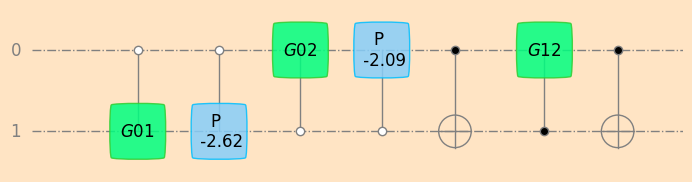

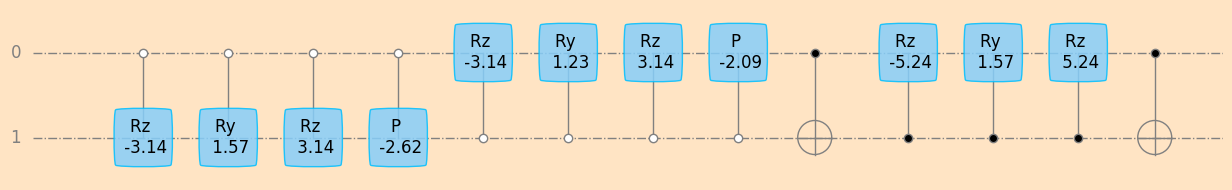

In [3]:
f3i1 = np.zeros((4, 4), dtype=complex)
w3 = np.exp(-2 * math.pi * 1j / 3)
for i in range(3):
    for j in range(3):
        f3i1[i][j] = w3 ** (i * j) / math.sqrt(3)
f3i1[3][3] = 1

# decompose f3i1 into CNOT, Givens, and Phase gates
seq_f3i1_givens, f3i1_params_givens = unitaryDecomposer(f3i1)
sim1 = simulatorUnitarySymPy(2)
sim1.values = f3i1_params_givens
plot_mpl(seq_f3i1_givens, backend=sim1, style="geqo")

# decompose the Givens operators into Ry and Rz gates
seq_f3i1, f3i1_params = unitaryDecomposer(f3i1, decompose_givens=True)
sim2 = simulatorStatevectorNumpy(2, 0)
sim2.values = f3i1_params
plot_mpl(seq_f3i1, backend=sim2, style="geqo")

# verify if the decomposed sequence is equivalent to the F3I1 gate
sim = simulatorUnitarySymPy(2)
sim.values = f3i1_params
sim.setValue("f3i1", f3i1)
sim.apply(BasicGate("f3i1", 2), [0, 1])
sim.apply(seq_f3i1.getInverse(), [0, 1])
u_f3i1 = sim.u
np.allclose(
    np.array(u_f3i1).astype(np.complex128),
    np.identity(4).astype(np.complex128),
    rtol=1e-05,
    atol=1e-08,
)

## Example: Decomposition of two arbitrary unitaries
- the decomposition algorithm does not use the structure of a matrix and can be applied to arbitrary unitary matrices
- the following two examples show the application of `unitaryDecomposer` to the unitaries corresponding to two randomly chosen circuits

True

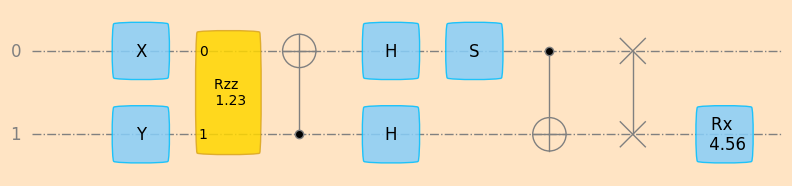

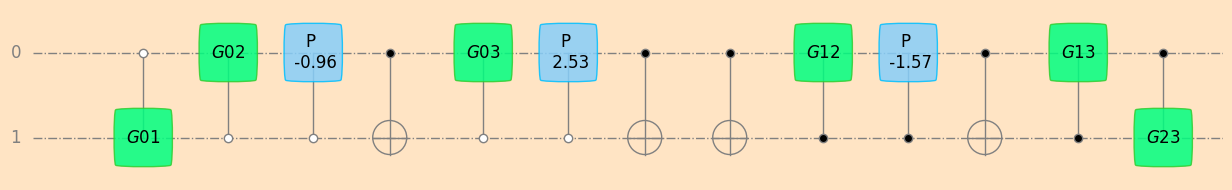

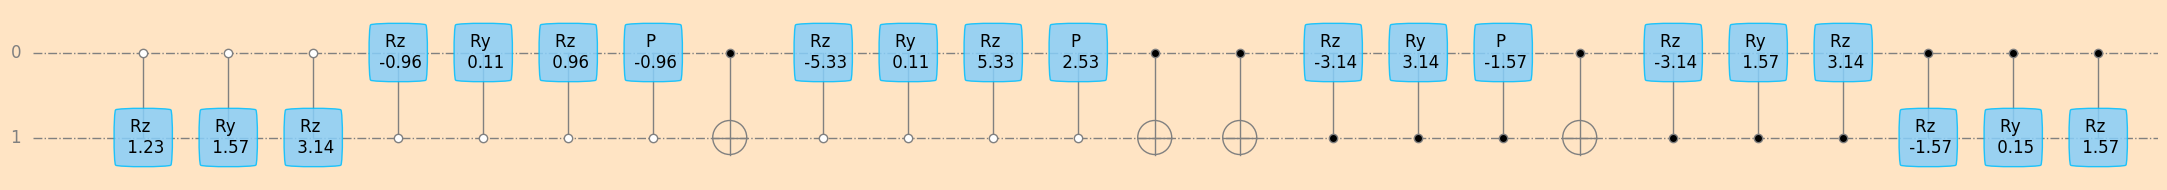

In [4]:
# build a random circuit
random1 = Sequence(
    [0, 1],
    [],
    [
        (PauliX(), [0], []),
        (PauliY(), [1], []),
        (Rzz("a"), [0, 1], []),
        (CNOT(), [1, 0], []),
        (Hadamard(), [1], []),
        (Hadamard(), [0], []),
        (SGate(), [0], []),
        (CNOT(), [0, 1], []),
        (SwapQubits(), [0, 1], []),
        (Rx("b"), [1], []),
    ],
)
sim = simulatorUnitarySymPy(2)
sim.setValue("a", 1.23)
sim.setValue("b", 4.56)
sim.apply(random1, [0, 1])
u1 = sim.u

plot_mpl(random1, backend=sim, style="geqo")

# decompose random unitary u1 into CNOT, Givens, and Phase gates
seq_u1_givens, u1_params_givens = unitaryDecomposer(u1)
sim1 = simulatorUnitarySymPy(2)
sim1.values = u1_params_givens
plot_mpl(seq_u1_givens, backend=sim1, style="geqo")

# decompose the Givens operators into Ry and Rz gates
seq_u1, u1_params = unitaryDecomposer(u1, decompose_givens=True)
sim2 = simulatorStatevectorNumpy(2, 0)
sim2.values = u1_params
plot_mpl(seq_u1, backend=sim2, style="geqo")

# verify if the decomposed sequence is equivalent to the u1 gate
sim = simulatorUnitarySymPy(2)
sim.values = u1_params
sim.setValue("u1", u1)
sim.apply(BasicGate("u1", 2), [0, 1])
sim.apply(seq_u1.getInverse(), [0, 1])
test_u1 = sim.u
np.allclose(
    np.array(test_u1).astype(np.complex128),
    np.identity(4).astype(np.complex128),
    rtol=1e-05,
    atol=1e-08,
)

True

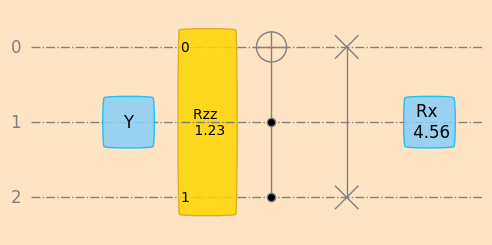

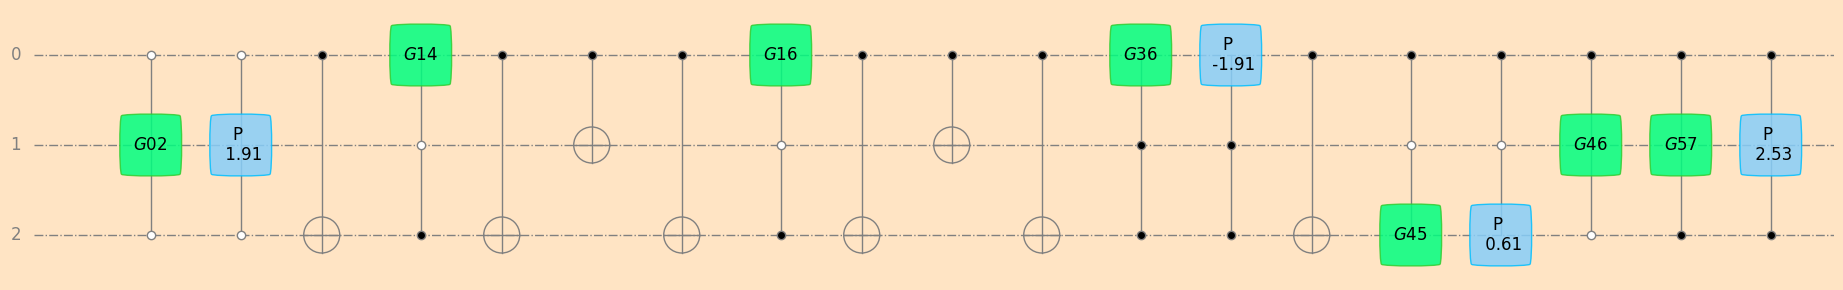

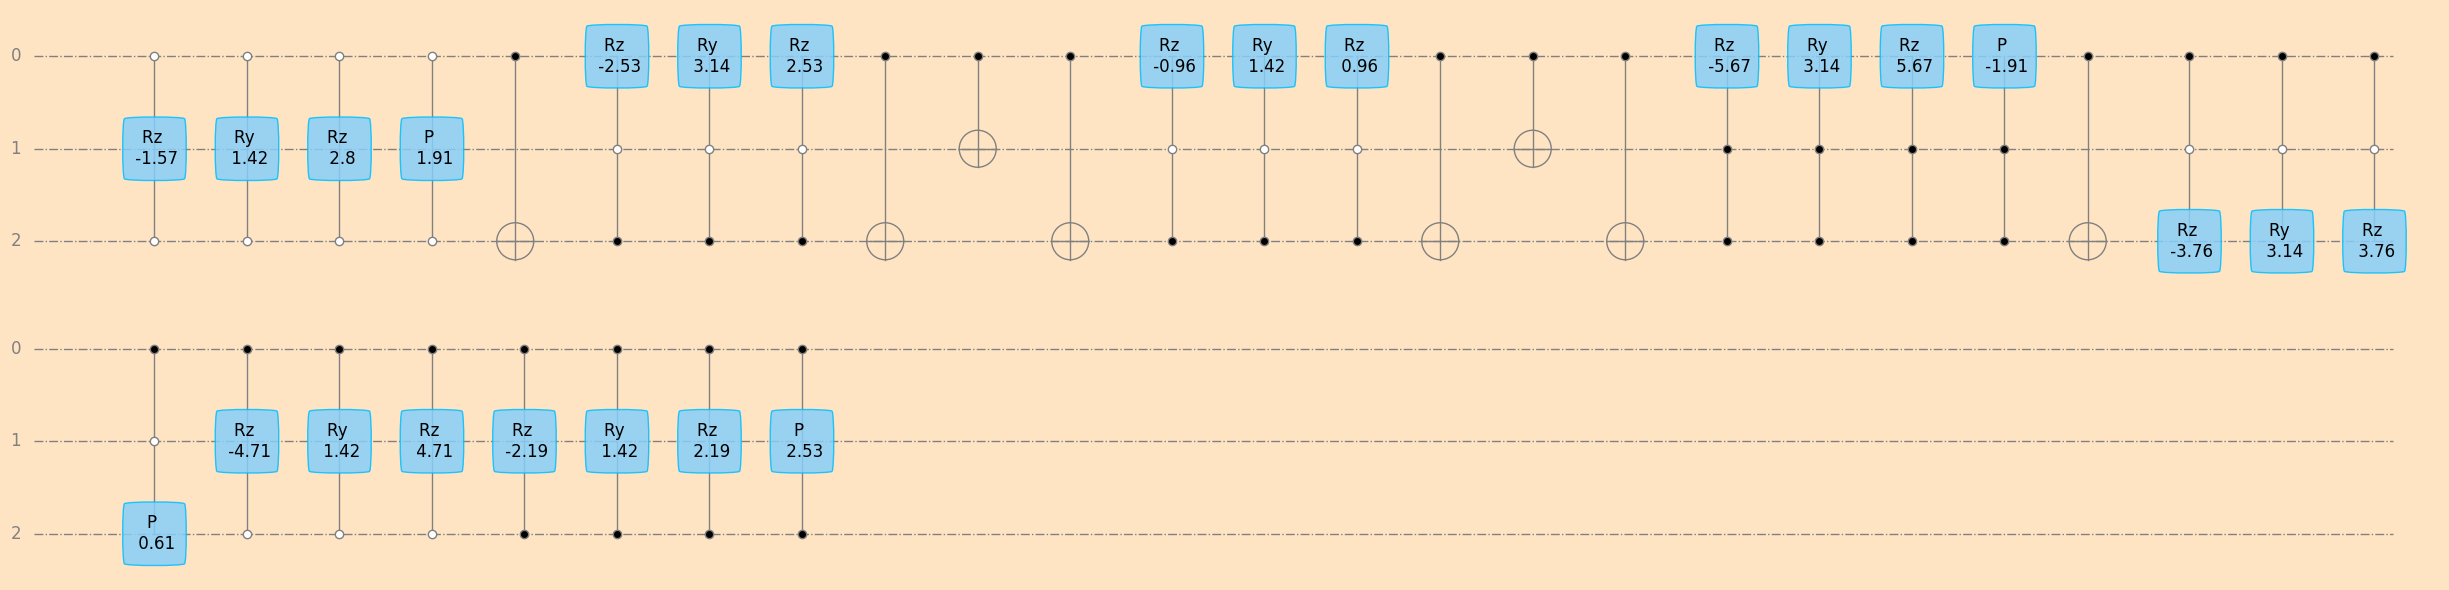

In [5]:
random2 = Sequence(
    [0, 1, 2],
    [],
    [
        (PauliY(), [1], []),
        (Rzz("a"), [0, 2], []),
        (Toffoli(), [2, 1, 0], []),
        (SwapQubits(), [0, 2], []),
        (Rx("b"), [1], []),
    ],
)

sim = simulatorUnitarySymPy(3)
sim.setValue("a", 1.23)
sim.setValue("b", 4.56)
sim.prepareBackend([Toffoli()])
sim.apply(random2, [0, 1, 2])
u2 = sim.u

plot_mpl(random2, backend=sim, style="geqo")

# decompose random unitary u2 into CNOT, Givens, and Phase gates
seq_u2_givens, u2_params_givens = unitaryDecomposer(u2)
sim1 = simulatorUnitarySymPy(3)
sim1.values = u2_params_givens
plot_mpl(seq_u2_givens, backend=sim1, style="geqo")

# decompose the Givens operators into Ry and Rz gates
seq_u2, u2_params = unitaryDecomposer(u2, decompose_givens=True)
sim2 = simulatorStatevectorNumpy(3, 0)
sim2.values = u2_params
plot_mpl(seq_u2, backend=sim2, style="geqo")

# verify if the decomposed sequence is equivalent to the u2 gate
sim = simulatorUnitarySymPy(3)
sim.values = u2_params
sim.setValue("u2", u2)
sim.apply(BasicGate("u2", 3), [0, 1, 2])
sim.apply(seq_u2.getInverse(), [0, 1, 2])
test_u2 = sim.u
np.allclose(
    np.array(test_u2).astype(np.complex128),
    np.identity(8).astype(np.complex128),
    rtol=1e-05,
    atol=1e-08,
)